# THIS ONE THIS ONE Train a Simple Audio Recognition Model

This notebook demonstrates how to train a 20 kB [Simple Audio Recognition](https://www.tensorflow.org/tutorials/sequences/audio_recognition) model to recognize keywords in speech.

The model created in this notebook is used in the [micro_speech](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/micro_speech) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/micro_speech/train/train_micro_speech_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/micro_speech/train/train_micro_speech_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


**Training is much faster using GPU acceleration.** Before you proceed, ensure you are using a GPU runtime by going to **Runtime -> Change runtime type** and set **Hardware accelerator: GPU**. Training 15,000 iterations will take 1.5 - 2 hours on a GPU runtime.

## Configure Defaults

**MODIFY** the following constants for your specific use case.

In [90]:
# A comma-delimited list of the words you want to train for.
# The options are: yes,no,up,down,left,right,on,off,stop,go
# All the other words will be used to train an "unknown" label and silent
# audio data with no spoken words will be used to train a "silence" label.
WANTED_WORDS = "snoring,no_snoring"

# The number of steps and learning rates can be specified as comma-separated
# lists to define the rate at each stage. For example,
# TRAINING_STEPS=12000,3000 and LEARNING_RATE=0.001,0.0001
# will run 12,000 training loops in total, with a rate of 0.001 for the first
# 8,000, and 0.0001 for the final 3,000.
TRAINING_STEPS = "25,25"
LEARNING_RATE = "0.005,0.003"
WINDOW_STRIDE = 20
PREPROCESS = "micro"
#DATASET_DIR = '/home/jiayu/Desktop/Snoring-Detection/Snoring_Dataset_@16000/'
DATASET_DIR = '/Users/yannbaglinbunod/Desktop/Coussin/Snoring-Detection/Snoring_Dataset_@16000'
# Calculate the total number of steps, which is used to identify the checkpoint
# file name.
TOTAL_STEPS = str(sum(map(lambda string: int(string), TRAINING_STEPS.split(","))))
LOGS_DIR = 'logs/'
# Print the configuration to confirm it
print("Training these words: %s" % WANTED_WORDS)
print("Training steps in each stage: %s" % TRAINING_STEPS)
print("Learning rate in each stage: %s" % LEARNING_RATE)
print("Total number of training steps: %s" % TOTAL_STEPS)

Training these words: snoring,no_snoring
Training steps in each stage: 25,25
Learning rate in each stage: 0.005,0.003
Total number of training steps: 50


In [91]:
import sys
sys.path.append("../deployment/tensorflow1/tensorflow/examples/speech_commands/")
import input_data
import models

SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 30.0
FEATURE_BIN_COUNT = 40
BACKGROUND_FREQUENCY = 0
BACKGROUND_VOLUME_RANGE = 0
TIME_SHIFT_MS = 0.0
SILENCE = 10
DATA_URL = '' #'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10


# In[36]:


model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)
audio_processor = input_data.AudioProcessor(
    data_url=DATA_URL, data_dir=DATASET_DIR,silence_percentage=SILENCE,unknown_percentage=10,
    wanted_words=WANTED_WORDS.split(','), validation_percentage=VALIDATION_PERCENTAGE,
    testing_percentage=TESTING_PERCENTAGE, model_settings=model_settings, summaries_dir=LOGS_DIR)


In [92]:
# Check version of python using
# https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084
import sys
print(sys.executable)

/Users/yannbaglinbunod/miniconda3/envs/x/bin/python


In [93]:
import numpy as np
from scipy.io.wavfile import read as wav_read
import io,os
import ffmpeg
import librosa
import scipy.io.wavfile
import tensorflow as tf

In [94]:
# Helper function to run inference (on a single input this time)
# Note: this also includes additional manual pre-processing
def run_tflite_inference_singleFile(tflite_model_path, custom_audio, sr_custom_audio, model_type="Float"):
  #
  # Preprocess the sample to get the features we pass to the model
  #
  # First re-sample to the needed rate
#   custom_audio_resampled = librosa.resample(np.float64(custom_audio), sr_custom_audio, SAMPLE_RATE)
#   # Then extract the loudest one second
#   scipy.io.wavfile.write('custom_audio.wav', SAMPLE_RATE, np.int16(custom_audio_resampled))
#   os.system('./extract_loudest_section/gen/bin/extract_loudest_section custom_audio.wav ./trimmed')
#   # Finally pass it through the TFLiteMicro preprocessor to produce the 
#   # spectrogram/MFCC input that the model expects
#   custom_model_settings = models.prepare_model_settings(
#       0, SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
#       WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)

  custom_audio_processor = input_data.AudioProcessor(
                                        data_url=None, data_dir=None,silence_percentage=50,unknown_percentage=0,
                                        wanted_words='', validation_percentage=0,
                                        testing_percentage=0, model_settings=model_settings, summaries_dir=LOGS_DIR)
  custom_audio_preprocessed = custom_audio_processor.get_features_for_wav(
                                        custom_audio, model_settings, TF_SESS)
  # Reshape the output into a 1,1960 matrix as that is what the model expects
  custom_audio_input = custom_audio_preprocessed[0].flatten()
#   print (custom_audio_input)
#   custom_audio_input = custom_audio
#   print (custom_audio_input)

  test_data = np.reshape(custom_audio_input,(1,len(custom_audio_input)))

  #
  # Initialize the interpreter
  #
  interpreter = tf.lite.Interpreter(tflite_model_path)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  #
  # For quantized models, manually quantize the input data from float to integer
  #
  if model_type == "Quantized":
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])

  #
  # Run the interpreter
  #
  interpreter.set_tensor(input_details["index"], test_data)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details["index"])[0]
  top_prediction = output.argmax()

  #
  # Translate the output
  #
  top_prediction_str = ''
  if top_prediction == 0 or top_prediction == 1:
    top_prediction_str = WANTED_WORDS.split(',')[top_prediction]
  elif top_prediction == 2:
    top_prediction_str = 'silence'
  else:
    raiseError('Label not defined')

  print('%s model guessed the value to be %s' % (model_type, top_prediction_str))

  return top_prediction_str


In [95]:
# Use an interactive session.
TF_SESS = tf.compat.v1.InteractiveSession()

print("Testing snoring")
run_tflite_inference_singleFile(
    'conv_micro/conv_model.tflite',
    os.path.join(DATASET_DIR, 'snoring', '1_1.wav'),
    16000,
    model_type="Quantized")

print("Testing no snoring")
run_tflite_inference_singleFile(
    'conv_micro/conv_model.tflite',
    os.path.join(DATASET_DIR, 'no_snoring', '0_11.wav'),
    16000,
    model_type="Quantized")

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.
Testing snoring
Quantized model guessed the value to be snoring
Testing no snoring
Quantized model guessed the value to be no_snoring


'no_snoring'

In [96]:
import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

# Dataset path and parameters
DATASET_DIR = '/Users/yannbaglinbunod/Desktop/Coussin/Snoring-Detection/Snoring_Dataset_@16000'
SEGMENT_DURATION = 1.0  # seconds
SAMPLE_RATE = 16000

def segment_audio(file_path, segment_duration=1.0, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr)
    segment_samples = int(sr * segment_duration)
    segments = []
    for i in range(0, len(audio), segment_samples):
        seg = audio[i:i+segment_samples]
        if len(seg) < segment_samples:
            seg = np.pad(seg, (0, segment_samples - len(seg)), mode='constant')
        segments.append(seg)
    return audio, segments

# Path to your long audio file
long_file = os.path.join(DATASET_DIR, 'test', 'your_43sec_file.wav')
print("Long file:", long_file)

# Segment the audio and load full waveform for plotting
audio_waveform, segments = segment_audio(long_file, SEGMENT_DURATION, SAMPLE_RATE)

# Run inference on each segment and collect labels
predictions = []
for i, seg in enumerate(segments):
    temp_filename = f'temp_seg_{i}.wav'
    sf.write(temp_filename, seg, SAMPLE_RATE)
    #print(f"Testing segment {i}")
    # run_tflite_inference_singleFile should return the predicted label (e.g. "snoring" or "no_snoring")
    pred = run_tflite_inference_singleFile('conv_micro/conv_model.tflite',
                                            temp_filename,
                                            SAMPLE_RATE,
                                            model_type="Quantized")
    predictions.append(pred)
    os.remove(temp_filename)



Long file: /Users/yannbaglinbunod/Desktop/Coussin/Snoring-Detection/Snoring_Dataset_@16000/test/your_43sec_file.wav
Quantized model guessed the value to be snoring
Quantized model guessed the value to be snoring
Quantized model guessed the value to be no_snoring
Quantized model guessed the value to be no_snoring
Quantized model guessed the value to be snoring
Quantized model guessed the value to be snoring
Quantized model guessed the value to be no_snoring
Quantized model guessed the value to be no_snoring
Quantized model guessed the value to be snoring
Quantized model guessed the value to be snoring
Quantized model guessed the value to be no_snoring
Quantized model guessed the value to be no_snoring
Quantized model guessed the value to be snoring
Quantized model guessed the value to be snoring
Quantized model guessed the value to be no_snoring
Quantized model guessed the value to be no_snoring
Quantized model guessed the value to be snoring
Quantized model guessed the value to be snor

In [97]:
print(predictions)


['snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'snoring', 'snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring', 'no_snoring', 'no_snoring', 'snoring', 'snoring']


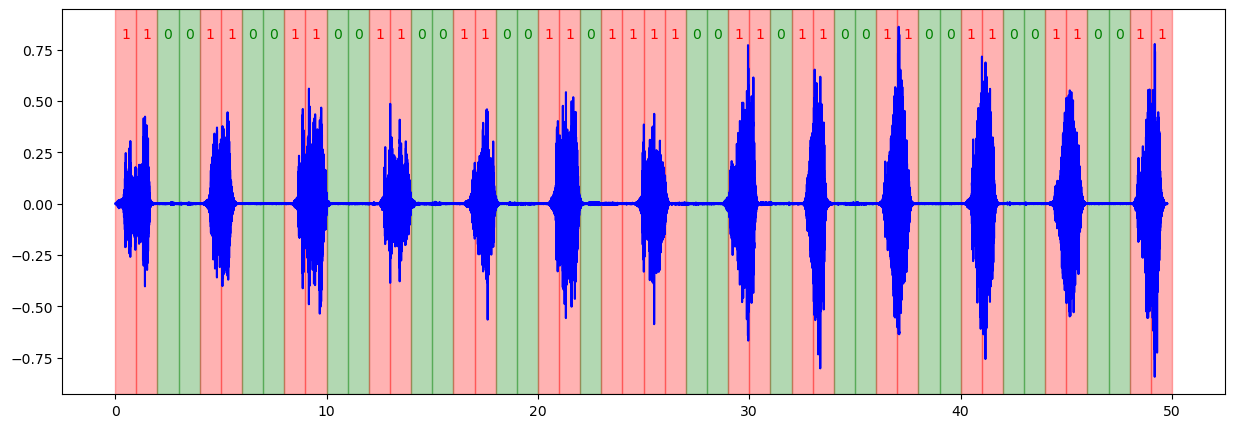

In [98]:
# Plot the waveform and overlay per-second labels
times = np.linspace(0, len(audio_waveform)/SAMPLE_RATE, num=len(audio_waveform))
plt.figure(figsize=(15, 5))
plt.plot(times, audio_waveform, label="Waveform", color='blue')

for i, label in enumerate(predictions):
    # Convert label to binary (1 for snoring, 0 for no_snoring)
    if label is None:
        binary_label = 0  # or choose a default
    else:
        binary_label = 1 if label.lower() == 'snoring' else 0
    # Use color based on binary value
    color = 'red' if binary_label == 1 else 'green'
    start_time = i * SEGMENT_DURATION
    end_time = (i + 1) * SEGMENT_DURATION
    plt.axvspan(start_time, end_time, color=color, alpha=0.3)
    mid_time = (start_time + end_time) / 2.0
    # Display the binary label (1 or 0)
    plt.text(mid_time, max(audio_waveform), str(binary_label), horizontalalignment='center',
             verticalalignment='top', fontsize=10, color=color)

In [107]:
import sounddevice as sd
import numpy as np
import os
import wave
import tensorflow as tf
from tensorflow.lite.python.interpreter import Interpreter
import input_data  # from your local "deployment/tensorflow1/tensorflow/examples/speech_commands/input_data.py"
import models      # from your local "deployment/tensorflow1/tensorflow/examples/speech_commands/models.py"

# ========== Settings ==========
SAMPLE_RATE        = 16000
SEGMENT_DURATION   = 1.0
MODEL_PATH         = 'conv_micro/conv_model.tflite'
TEMP_WAV           = 'temp_mic_input.wav'
WANTED_WORDS       = ['snoring','no_snoring']   # in training
CLIP_DURATION_MS   = 1000
WINDOW_SIZE_MS     = 30
WINDOW_STRIDE_MS   = 20
FEATURE_BIN_COUNT  = 40
PREPROCESS         = 'micro'  # e.g. 'mfcc' or 'micro', whichever you used
VALIDATION_PERCENT = 10
TEST_PERCENT       = 10
SILENCE_PERCENT    = 10
UNKNOWN_PERCENT    = 10

# ========== Create TF session & audio processor exactly as used in training ==========
tf.compat.v1.disable_eager_execution()

# Prepare model settings
model_settings = models.prepare_model_settings(
    label_count=len(WANTED_WORDS) + 2,  # +2 for SILENCE and UNKNOWN
    sample_rate=SAMPLE_RATE,
    clip_duration_ms=CLIP_DURATION_MS,
    window_size_ms=WINDOW_SIZE_MS,
    window_stride_ms=WINDOW_STRIDE_MS,
    feature_bin_count=FEATURE_BIN_COUNT,
    preprocess=PREPROCESS
)

# Create an AudioProcessor. We pass dummy dataset args if we only want to process real-time input:
audio_processor = input_data.AudioProcessor(
    data_url=None, 
    data_dir=None, 
    silence_percentage=SILENCE_PERCENT,
    unknown_percentage=UNKNOWN_PERCENT, 
    wanted_words=WANTED_WORDS, 
    validation_percentage=VALIDATION_PERCENT, 
    testing_percentage=TEST_PERCENT, 
    model_settings=model_settings,
    summaries_dir=None
)

# Make a TF session for running the “get_features_for_wav” operation:
TF_SESS = tf.compat.v1.Session()

# ========== Load TFLite model ==========
interpreter = Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def record_audio(duration=1.0, sr=16000):
    """
    Record audio from microphone into a numpy array (float32).
    """
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    return audio.flatten()

def save_wav(filename, audio_data, sample_rate=16000):
    """
    Save a float32 numpy array to a 16-bit PCM WAV file.
    """
    # Scale to int16
    scaled = np.int16(audio_data * 32767)
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)  # 16-bit
        wf.setframerate(sample_rate)
        wf.writeframes(scaled.tobytes())

while True:
    # 1. Record 1-second audio
    audio_chunk = record_audio(SEGMENT_DURATION, SAMPLE_RATE)

    # 2. Save to temp WAV so we can use input_data.py’s existing function
    save_wav(TEMP_WAV, audio_chunk, SAMPLE_RATE)

    # 3. Generate features with the same pipeline as training
    features_tensor = audio_processor.get_features_for_wav(
        TEMP_WAV, model_settings, TF_SESS
    )
    # This returns a list with one element (the features). Flatten & reshape if needed.
    features = features_tensor[0]
    # Usually shape is (1, 49, 40) or (1, 1960) etc. You may need to verify shape.
    # Flatten to match the TFLite model’s input shape:
    input_data = features.flatten().reshape(1, -1)

    # 4. If model is quantized, scale the input_data:
    scale, zero_point = input_details[0]['quantization']
    if scale > 0: 
        # e.g. for int8
        input_data = (input_data / scale + zero_point).astype(np.int8)

    # 5. Run inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    predicted_index = np.argmax(output_data)

    # 6. Decode the prediction
    # In your training code, label 0 was "snoring", label 1 was "no_snoring", 2 for "silence", etc.
    if predicted_index == 0:
        label = "snoring"
    elif predicted_index == 1:
        label = "no_snoring"
    else:
        label = "other"

    print("Prediction:", label)

Prediction: no_snoring
Prediction: no_snoring
Prediction: snoring
Prediction: snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: snoring
Prediction: snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: snoring
Prediction: snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: snoring
Prediction: snoring
Prediction: snoring
Prediction: snoring
Prediction: snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring
Prediction: no_snoring


KeyboardInterrupt: 